# Recommendation engine (part 2)
This notebook is inspired by the following articles:
- __DEEP BEERS: Playing with Deep Recommendation Engines Using Keras__  
https://medium.com/data-from-the-trenches/deep-beers-playing-with-deep-recommendation-engines-using-keras-part-1-1efc4779568f
- __Recommender Systems in Keras__
https://nipunbatra.github.io/blog/2017/recommend-keras.html
- __Neural Networks for Collaborative Filtering__
https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html

In this notebook, we will discover how to implement a recommendation engine with `Keras`.

## Introduction


# Implementation 

We will download the MovieLens dataset (http://grouplens.org/datasets/movielens/100k/). We focus only on a subpart of the whole MovieLensdataset (100,000 ratings from 1000 users on 1700 movies).

Documentation about the dataset can be found here: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = 50

In [2]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')


In [3]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Building an explicit recommendation engine

It basically boils down to a regression problem where we try to predict the ratings for each user. This means that a movie will be recommended to a user that (s)he is likely to rate highly.

The first model will be based on a matrix factorisation approach. The idea is to project movie and users in a common latent space.

In [12]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

Since movie and user ids are numbered from 1, we need to make these counters starts from 0 to be compatible with keras Embedding layers.

In [13]:
ratings["movie_id"] -= 1
ratings["user_id"]  -= 1

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


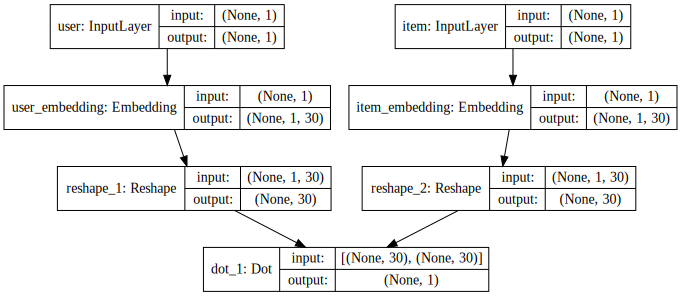

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=n_items,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

# input_vecs = Concatenate()([user_vecs, item_vecs])
# x = Dense(128, activation='relu')(input_vecs)
# y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Let's create two user-item matrices, one for training and another for testing

In [15]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size=0.25)

In [16]:
history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=20,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/20
67500/67500 [==============================] - 6s 87us/step - loss: 11.2149 - val_loss: 4.1321
Epoch 2/20
67500/67500 [==============================] - 5s 73us/step - loss: 2.0061 - val_loss: 1.2457
Epoch 3/20
67500/67500 [==============================] - 5s 72us/step - loss: 1.0968 - val_loss: 0.9972
Epoch 4/20
67500/67500 [==============================] - 4s 65us/step - loss: 0.9574 - val_loss: 0.9269
Epoch 5/20
67500/67500 [==============================] - 4s 66us/step - loss: 0.9126 - val_loss: 0.9132
Epoch 6/20
67500/67500 [==============================] - 5s 69us/step - loss: 0.8926 - val_loss: 0.8993
Epoch 7/20
67500/67500 [==============================] - 4s 56us/step - loss: 0.8786 - val_loss: 0.8892
Epoch 8/20
67500/67500 [==============================] - 4s 64us/step - loss: 0.8656 - val_loss: 0.8859
Epoch 9/20
67500/67500 [==============================] - 4s 62us/step - loss: 0.8492 - val_loss: 0.8740
Epoch

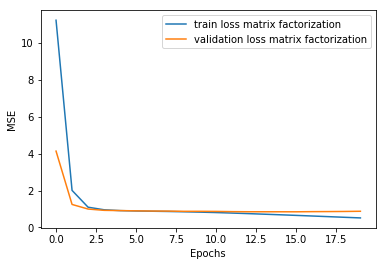

In [17]:
plt.figure()
plt.plot(history.history["loss"], label="train loss matrix factorization")
plt.plot(history.history["val_loss"], label="validation loss matrix factorization")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

Here again, there could be some parameter optimization, especially concerning the number of latent vectors (or embedding size).

### Non-negative Matrix Factorization



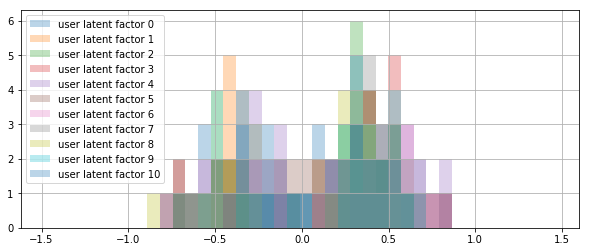

In [18]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

plt.figure(figsize=(10,4))
for i in range(user_embedding_learnt.shape[-1]):
    pd.Series(user_embedding_learnt[i]).hist(alpha=0.3, 
                                             bins=40, 
                                             range=(user_embedding_learnt.min(), user_embedding_learnt.max()), label="user latent factor "+str(i))
    if i >= 10:
        break
        
plt.legend()

We can see that both the user embeddings (as well as the item embeddings) have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

In [19]:
from keras.constraints import non_neg

user_id_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding', embeddings_constraint=non_neg())(user_id_input)
user_vecs = Reshape([embedding_size])(user_embedding)

item_id_input = Input(shape=[1], name='item')
item_embedding = Embedding(output_dim=embedding_size, input_dim=n_items,
                           input_length=1, name='item_embedding', embeddings_constraint=non_neg())(item_id_input)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")

history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=20,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/10
67500/67500 [==============================] - 9s 128us/step - loss: 7.5337 - val_loss: 2.1926
Epoch 2/10
67500/67500 [==============================] - 7s 100us/step - loss: 1.4950 - val_loss: 1.1315
Epoch 3/10
67500/67500 [==============================] - 7s 108us/step - loss: 1.0396 - val_loss: 0.9662
Epoch 4/10
67500/67500 [==============================] - 7s 104us/step - loss: 0.9443 - val_loss: 0.9191
Epoch 5/10
67500/67500 [==============================] - 5s 67us/step - loss: 0.9134 - val_loss: 0.9106
Epoch 6/10
67500/67500 [==============================] - 4s 58us/step - loss: 0.9009 - val_loss: 0.9034
Epoch 7/10
67500/67500 [==============================] - 6s 87us/step - loss: 0.8953 - val_loss: 0.8965
Epoch 8/10
67500/67500 [==============================] - 6s 84us/step - loss: 0.8906 - val_loss: 0.8904
Epoch 9/10
67500/67500 [==============================] - 5s 77us/step - loss: 0.8879 - val_loss: 0.8902
Ep

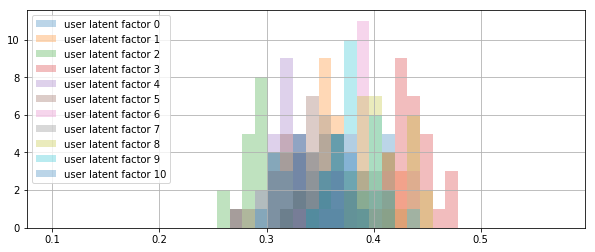

In [20]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

plt.figure(figsize=(10,4))
for i in range(user_embedding_learnt.shape[-1]):
    pd.Series(user_embedding_learnt[i]).hist(alpha=0.3, 
                                             bins=40, 
                                             range=(user_embedding_learnt.min(), user_embedding_learnt.max()), label="user latent factor "+str(i))
    if i >= 10:
        break
        
plt.legend()

### Neural networks for recommendation
We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
1. Due to #1, we can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.


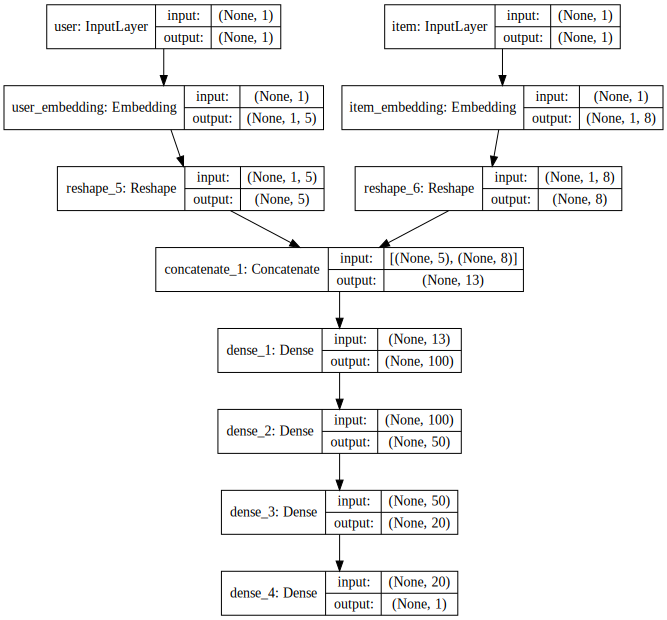

In [21]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

user_id_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=n_latent_factors_user, input_dim=n_users, input_length=1, name='user_embedding')(user_id_input)
user_vecs = Reshape([n_latent_factors_user])(user_embedding)

item_id_input = Input(shape=[1], name='item')
item_embedding = Embedding(output_dim=n_latent_factors_movie, input_dim=n_items, input_length=1, name='item_embedding')(item_id_input)
item_vecs = Reshape([n_latent_factors_movie])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])
x = Dense(100, activation='relu')(input_vecs)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")


SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [22]:
history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=20,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/20
67500/67500 [==============================] - 6s 84us/step - loss: 1.3848 - val_loss: 0.8675
Epoch 2/20
67500/67500 [==============================] - 5s 67us/step - loss: 0.8946 - val_loss: 0.8601
Epoch 3/20
67500/67500 [==============================] - 4s 55us/step - loss: 0.8799 - val_loss: 0.8464
Epoch 4/20
67500/67500 [==============================] - 5s 67us/step - loss: 0.8558 - val_loss: 0.8364
Epoch 5/20
67500/67500 [==============================] - 4s 53us/step - loss: 0.8330 - val_loss: 0.8359
Epoch 6/20
67500/67500 [==============================] - 3s 49us/step - loss: 0.8153 - val_loss: 0.8284
Epoch 7/20
67500/67500 [==============================] - 4s 57us/step - loss: 0.8000 - val_loss: 0.8357
Epoch 8/20
67500/67500 [==============================] - 7s 99us/step - loss: 0.7858 - val_loss: 0.8330
Epoch 9/20
67500/67500 [==============================] - 7s 105us/step - loss: 0.7728 - val_loss: 0.8300
Epoch

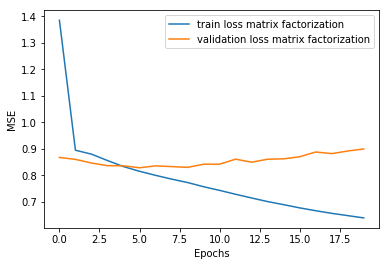

In [23]:
plt.figure()
plt.plot(history.history["loss"], label="train loss matrix factorization")
plt.plot(history.history["val_loss"], label="validation loss matrix factorization")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()